# Time-depenent ROC Analysis

Here we will look at how the approval year of a compound for an indication, relative to the year of the network, affects the ROC.  For example, do we get better predictions for Compounds apporved 3 years after than network year than 5 years?  

In [1]:
import os
import sys
sys.path.append('../../../hetnet-ml/src')

import time
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import logit

import graph_tools as gt
from extractor import MatrixFormattedGraph
import plot_tools as pt

DATA_DIR = '../../data/'

paper_figs = os.path.join(DATA_DIR, 'figures/paper_figs')
supp_figs = os.path.join(DATA_DIR, 'figures/supp_figs')
other_figs = os.path.join(DATA_DIR, 'figures/other_figs')

In [2]:
from scipy import interp                                                             
from sklearn.metrics import precision_recall_curve, roc_curve, auc        

In [3]:
def skip_ticks(tick_delta=2, angle=0):
    locs, labels = plt.xticks(rotation=angle)
    plt.xticks(locs[::tick_delta], labels[::tick_delta])

In [4]:
preds = []

base_dir = os.path.join(DATA_DIR, 'time_networks-6_metanode/')
max_indication_network_diff = 0
alpha = .1
scoring = 'recall'
negative_multiplier = 10
min_pmids = 2
gs_treat = False
w=0.6
                                                                                         
test_params = os.path.join('alpha_{}'.format(alpha), '{}x_pos-neg'.format(negative_multiplier), '{}_year_diff'.format(max_indication_network_diff))

if scoring != 'roc_auc':                                                                                                
    test_params = os.path.join(test_params, '{}-scoring'.format(scoring))                                               

if min_pmids > 1:                                                                                                       
    test_params = os.path.join(test_params, '{}_pmids'.format(min_pmids))                                               

if gs_treat:                                                                                                            
    test_params = os.path.join(test_params, 'gs_treats')                                                                

if w != 0.4:
    test_params = os.path.join(test_params, 'dwpc_w_{}'.format(w))
    

# Only go up to 2015, so we don't do the current network where there are not Future predictions for test-set    
years = [str(y) for y in range(1950, 2020, 1)]
    
for year in years:
    out_dir = os.path.join(base_dir, year, test_params)
    pred = pd.read_csv(os.path.join(out_dir, 'predictions.csv'))
    #pred['predictile'] = calc_percentile(pred, 'all_probas')
    pred['network_year'] = year
    preds.append(pred)

In [5]:
preds = pd.concat(preds)

In [6]:
preds.head(2)

,cd_id,cd_name,do_id,do_name,status,approval_year,year_diff,year_cat,dataset,test_probas,all_probas,cd_percentile,do_percentile,network_year
0,D005998,Glycine,C0001263,Abdominal actinomycosis,0,NaN,NaN,NaN,unused,NaN,0.00861,0.379167,0.006452,1950
1,D010837,Vitamin K 1,C0001263,Abdominal actinomycosis,0,NaN,NaN,NaN,unused,NaN,0.00863,0.341667,0.012903,1950


In [7]:
preds['network_year'].nunique()

70

## Combining the results of the different models...

The models for each year may have different probability distributions, so a given probablitiy might not mean the same thing between years.  A straightforward combination of all the model years might not make sense.  

Lets plot and look at alternatives to taking the staright probabilities.

/opt/mmayers/software/anaconda3/envs/integrate/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(-0.01, 1.01)

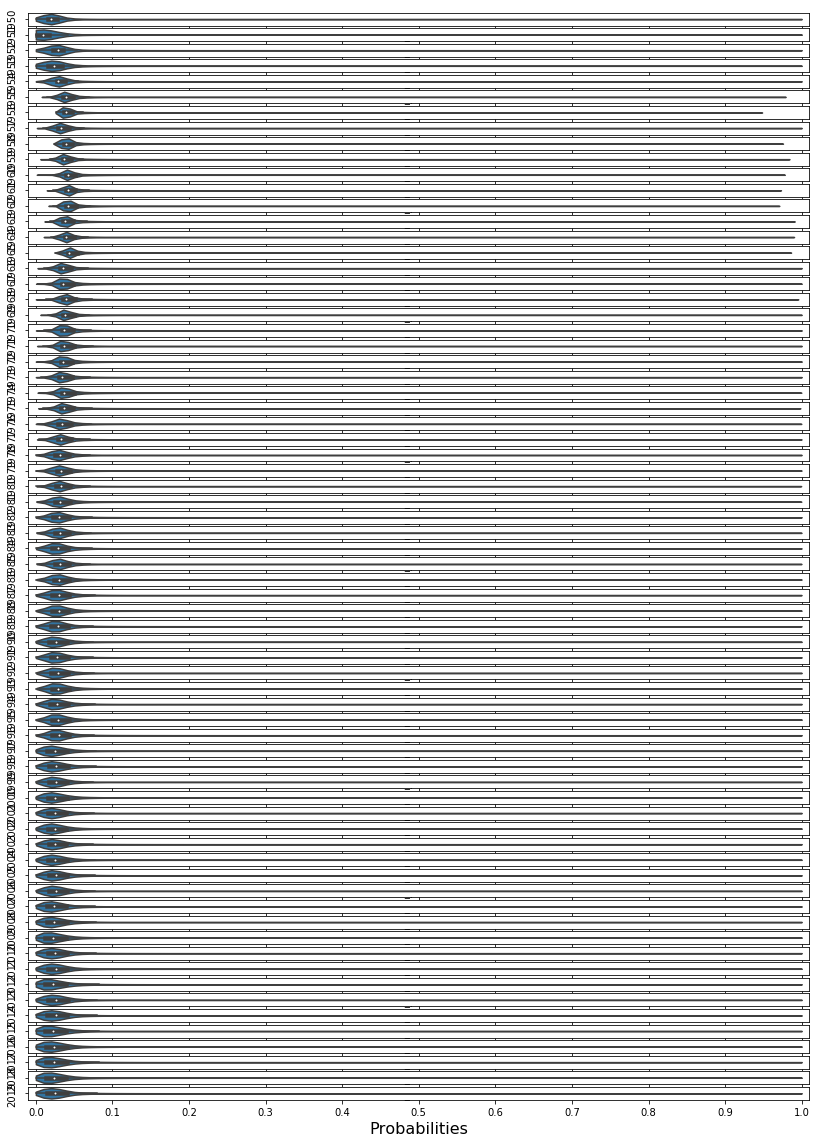

In [8]:
fig, ax = plt.subplots(len(years), 1, sharex=True)
fig.set_size_inches(14, 20)
fig.set_tight_layout(False)

for i, year in enumerate(years):
    
    sns.violinplot(x=preds.query('network_year == @year')['all_probas'], scale='width', cut=0, ax=ax[i])
    
    ax[i].set_ylabel(year)

plt.xlabel('Probabilities', size=16)
plt.yticks(size=16)
plt.xticks(np.arange(0, 1.01, .1))
plt.xlim(-.01, 1.01)

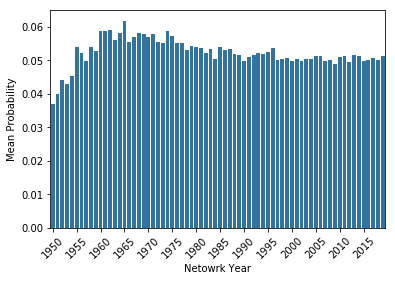

In [9]:
data=preds.groupby('network_year')['all_probas'].mean().reset_index()
sns.barplot(x='network_year', y='all_probas', data=data, color=sns.color_palette()[0])

plt.xlabel('Netowrk Year')
plt.ylabel('Mean Probability')
skip_ticks(5, 45);

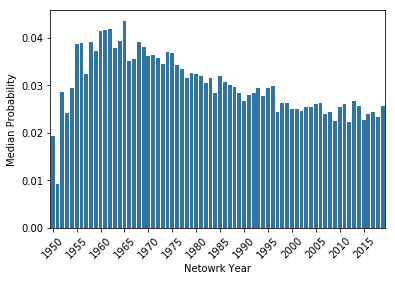

In [10]:
data=preds.groupby('network_year')['all_probas'].median().reset_index()
sns.barplot(x='network_year', y='all_probas', data=data, color=sns.color_palette()[0])

plt.xlabel('Netowrk Year')
plt.ylabel('Median Probability')
skip_ticks(5, 45);

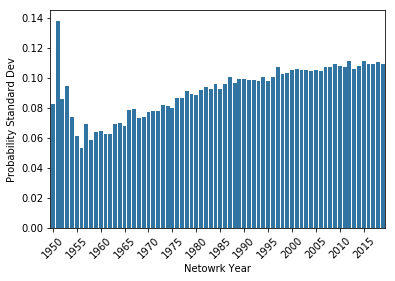

In [11]:
data=preds.groupby('network_year')['all_probas'].std().reset_index()
sns.barplot(x='network_year', y='all_probas', data=data, color=sns.color_palette()[0])

plt.xlabel('Netowrk Year')
plt.ylabel('Probability Standard Dev')
skip_ticks(5, 45);

Becasue the means on some of the modles are so far apart, a low-probability result from 1965 is automatically going to be favored over a low-probability result from 2010.

### Alternative 1: Take the percentile

This will essentially combine the models based on rank.  While this fix set all models to the same probability distribution, since the distribution is exopnential, two items with close (but low) probabilities may be very far apart in rank, and two items with a large gap in (but high) probabilites may be very very close in rank...

In [12]:
def calc_percentile(series):
    """
    Quick calculation of percentile as reverse_rank / total_numb_of_obs
    """
    
    # Get values needed for calculation
    total = len(series)
    name = series.name
    series = series.to_frame()
    
    rev_rank = (series.sort_values(name)          # sort by the values
                      .reset_index()              # re-index in new order
                      .reset_index()              # Turn sorted index into new column
                      .rename(columns={'level_0':'rev_rank'})  # Rename new sorted index column 'rev_rank'
                      .set_index('index')         # Reset the old index
                      .sort_index())['rev_rank']  # sort by original index to reset order
    rev_rank.index = rev_rank.index.rename(None)  # Remove new name of original index

    # reverse rank is zero-indexed, so add 1
    return ((rev_rank+1) / total)*100

In [13]:
preds['predictile'] = preds.groupby('network_year')['all_probas'].apply(calc_percentile)

## Alternative 2: Standardize each distribution

By converting all the probabilities to Z-socres, we will be looking at how extreme each prediction is within its own model, allowing for a better comparison between models

In [14]:
def standardize(data):
    """Quick funtion to sandardize a distribution"""
    mean_val = data.mean()
    std_val = data.std()
    
    return (data - mean_val) / std_val

In [15]:
preds['std_probas'] = preds.groupby('network_year')['all_probas'].apply(standardize)

/opt/mmayers/software/anaconda3/envs/integrate/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


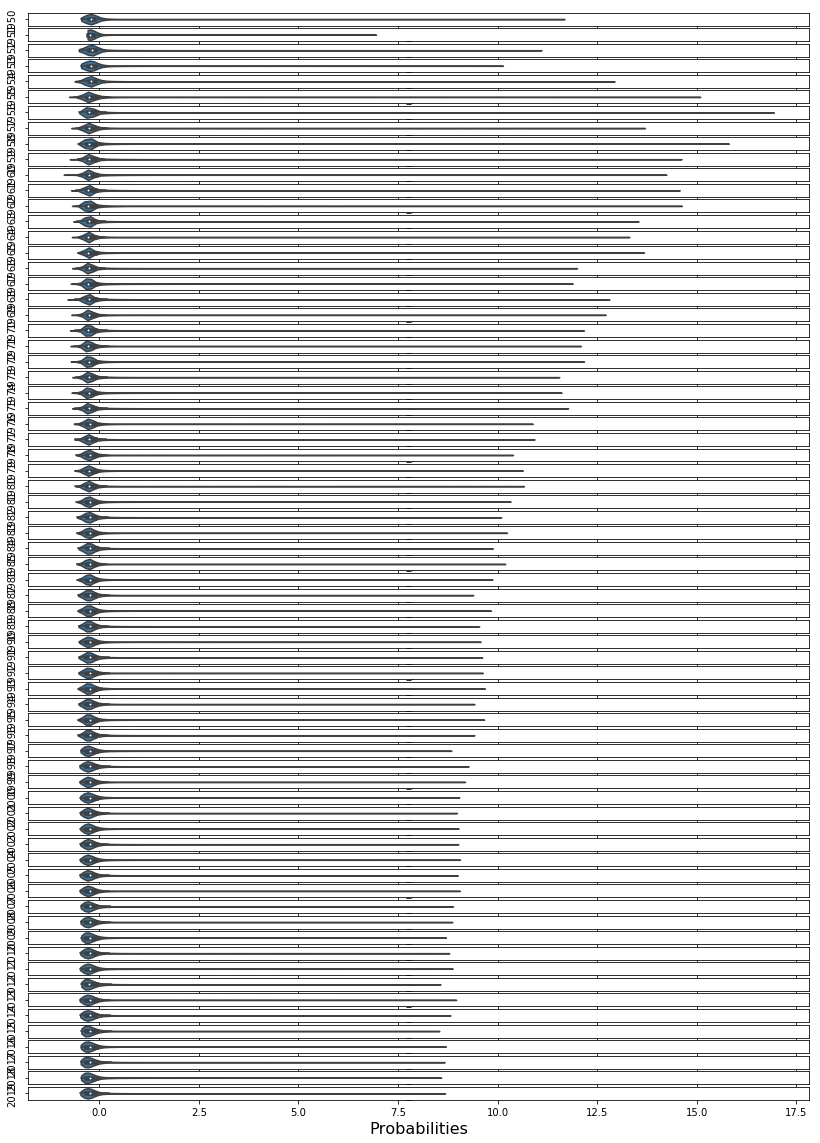

In [16]:
fig, ax = plt.subplots(len(years), 1, sharex=True)
fig.set_size_inches(14, 20)
fig.set_tight_layout(False)

for i, year in enumerate(years):
    
    sns.violinplot(x=preds.query('network_year == @year')['std_probas'], scale='width', cut=0, ax=ax[i])
    
    ax[i].set_ylabel(year)

plt.xlabel('Probabilities', size=16)
plt.yticks(size=16);

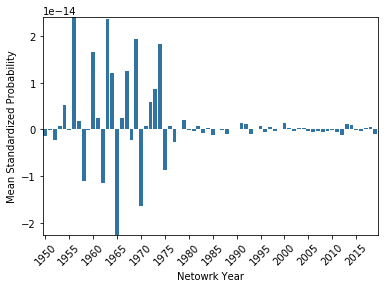

In [17]:
data=preds.groupby('network_year')['std_probas'].mean().reset_index()
sns.barplot(x='network_year', y='std_probas', data=data, color=sns.color_palette()[0])

plt.xlabel('Netowrk Year')
plt.ylabel('Mean Standardized Probability')
skip_ticks(5, 45);

All means are essentiall zero now

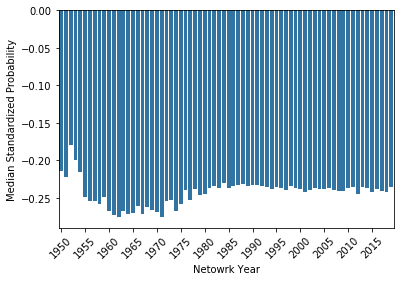

In [18]:
data=preds.groupby('network_year')['std_probas'].median().reset_index()
sns.barplot(x='network_year', y='std_probas', data=data, color=sns.color_palette()[0])

plt.xlabel('Netowrk Year')
plt.ylabel('Median Standardized Probability')
skip_ticks(5, 45);

There are still some differences in the median probability...

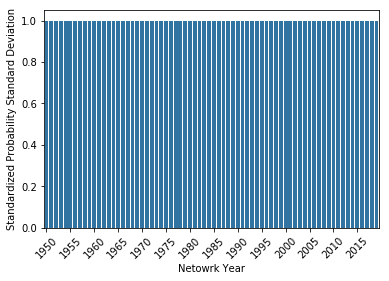

In [19]:
data=preds.groupby('network_year')['std_probas'].std().reset_index()
sns.barplot(x='network_year', y='std_probas', data=data, color=sns.color_palette()[0])

plt.xlabel('Netowrk Year')
plt.ylabel('Standardized Probability Standard Deviation')
skip_ticks(5, 45);

## Generate ROC curves for different compound approval categories

In [20]:
def get_year_category(diff):
    if diff > 20:
        return '21+ After'
    elif diff > 15 and diff <= 20:
        return '16-20 After'
    elif diff > 10 and diff <= 15:
        return '11-15 After'
    elif diff > 5 and diff <= 10:
        return '6-10 After'
    elif diff > 0 and diff <= 5:
        return '1-5 After'
    elif diff >= -5 and diff < 0:
        return '0-5 Before'
    elif diff >= -10 and diff < -5:
        return '6-10 Before'
    elif diff >= -15 and diff < -10:
        return '11-15 Before'
    elif diff >= -20 and diff < -15:
        return '16-20 Before'
    elif diff < -20:
        return '21+ Before'

In [21]:
preds['year_cat'] = preds['year_diff'].apply(get_year_category)

In [22]:
res = preds['year_cat'].value_counts()
res

21+ Before      116708
11-15 Before     22123
6-10 Before      22086
16-20 Before     21471
0-5 Before       21133
1-5 After        13091
6-10 After        6322
21+ After         4714
11-15 After       3571
16-20 After       2297
Name: year_cat, dtype: int64

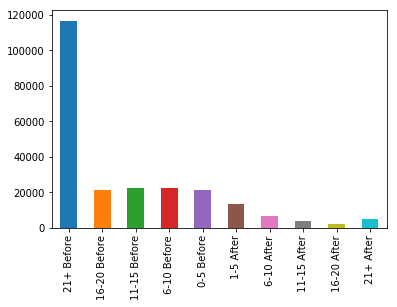

In [23]:
# Get DATA
res = preds['year_cat'].value_counts().to_frame()

# Make sure the X axis is properly Sorted
res['kind'] = res.index.str.split(' ', expand=True).labels[1]
# String splitting in indicies is NOT straight forward (see craziness)
craziness = res.index.str.replace('+', '-').str.split('-', expand=True)
res['diff'] = [int(craziness.levels[0][l]) for l in craziness.labels[0]]
# Invert the diffs sign on one kind
res['diff'] = res['diff'] * (res['kind'] - 1) + res['diff'] * (res['kind'])

res.sort_values('diff', ascending=False)['year_cat'].plot(kind='bar');

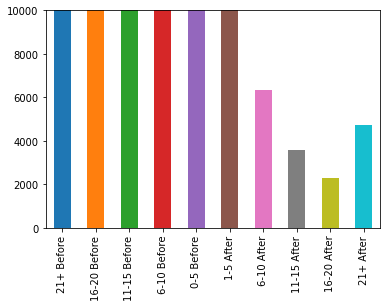

In [24]:
# Soom in a bit...
res.sort_values('diff', ascending=False)['year_cat'].plot(kind='bar')
plt.ylim([0, 10000]);

In [25]:
# data prep
year_cats = preds['year_cat'].dropna().unique()

prepped = {}
for i, cat in enumerate(year_cats):
        pos_subset = preds.query('year_cat == @cat and status == 1')
        neg_subset = preds.query('status == 0 and dataset != "train"').sample(len(pos_subset)*50, random_state=i)

        test_set = pd.concat([pos_subset, neg_subset])
        prepped[cat] = test_set

In [26]:
# Sorting the categories from oldest to newest... syntax is a bit of a pain..
year_cats = (sorted([y for y in year_cats if 'Before' in y], key=lambda s: int(s.replace('+', '-').split('-')[0]), reverse=True) + 
sorted([y for y in year_cats if 'After' in y], key=lambda s: int(s.replace('+', '-').split('-')[0])))

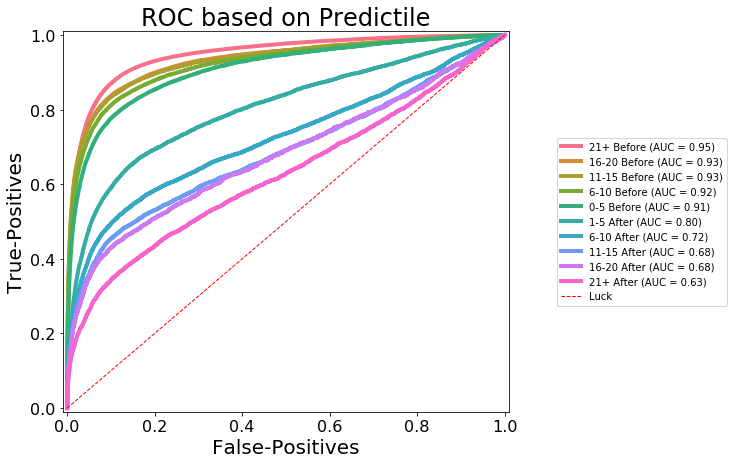

In [27]:
with sns.color_palette('husl', n_colors=len(year_cats)):

    for cat in year_cats:
        y_true = prepped[cat]['status']
        y_pred = prepped[cat]['predictile']
        pt.graph_single_roc(y_true, y_pred, label=cat)
    
    pt.graph_roc_boilerplate('ROC based on Predictile')
    plt.legend(loc='right', bbox_to_anchor=(1.5,.5));

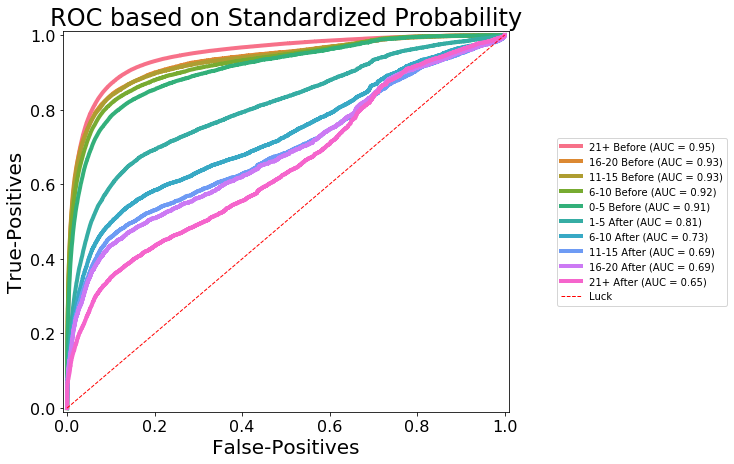

In [28]:
with sns.color_palette('husl', n_colors=len(year_cats)):

    for cat in year_cats:
        y_true = prepped[cat]['status']
        y_pred = prepped[cat]['std_probas']
        pt.graph_single_roc(y_true, y_pred, label=cat)
    
    pt.graph_roc_boilerplate('ROC based on Standardized Probability')
    plt.legend(loc='right', bbox_to_anchor=(1.5,.5));

There doesn't appear to be a huge difference between the Predicitle and standarized probaitlities.  For this reason we'll stick with standard probabilites for the remainder of the analysis.

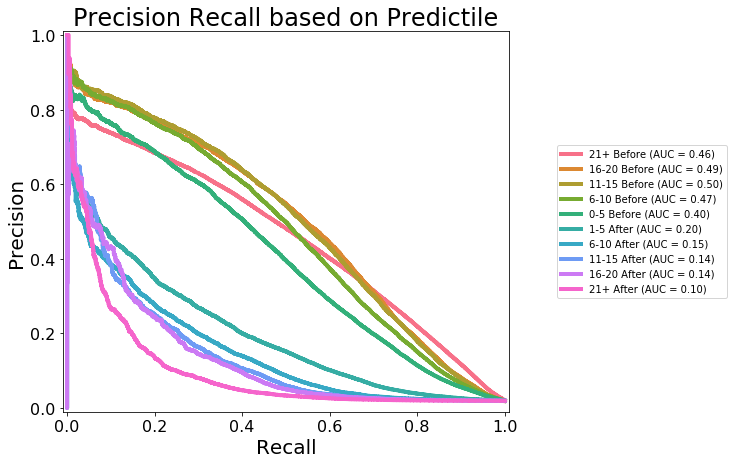

In [29]:
with sns.color_palette('husl', n_colors=len(year_cats)):

    for cat in year_cats:
        y_true = prepped[cat]['status']
        y_pred = prepped[cat]['predictile']
        pt.graph_single_prc(y_true, y_pred, label=cat)
    
    pt.graph_prc_boilerplate('Precision Recall based on Predictile')
    plt.legend(loc='right', bbox_to_anchor=(1.5,.5));

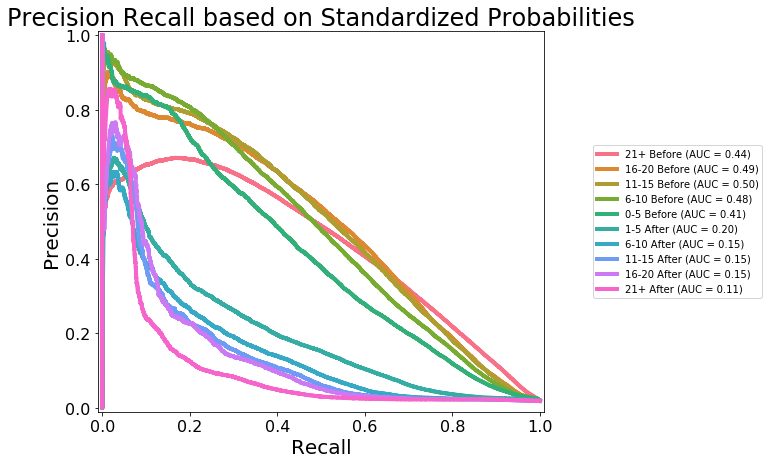

In [30]:
with sns.color_palette('husl', n_colors=len(year_cats)):

    for cat in year_cats:
        y_true = prepped[cat]['status']
        y_pred = prepped[cat]['std_probas']
        pt.graph_single_prc(y_true, y_pred, label=cat)
    
    pt.graph_prc_boilerplate('Precision Recall based on Standardized Probabilities')
    plt.legend(loc='right', bbox_to_anchor=(1.5,.5));

## Greater granularity of results AUC results (year by year)



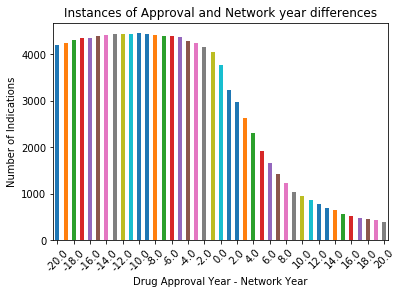

In [31]:
(preds.query('year_diff <= 20 and year_diff >= -20')['year_diff'].value_counts().sort_index()).plot(kind='bar')
plt.xlabel('Drug Approval Year - Network Year')
plt.ylabel('Number of Indications')
plt.title('Instances of Approval and Network year differences')
skip_ticks(2, 45);

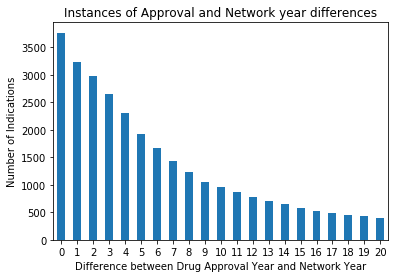

In [32]:
(preds.query('year_diff <= 20 and year_diff >= 0')['year_diff'].astype(int).value_counts().sort_index()).plot(kind='bar', color=sns.color_palette()[0])
plt.xlabel('Difference between Drug Approval Year and Network Year')
plt.ylabel('Number of Indications')
plt.xticks(rotation=0)
plt.title('Instances of Approval and Network year differences');

### Thresholds

Initally look at AUROC for drugs approved a minimum of X years beofre the network.  So for example, an X value of 9 = AUROC for drugs approved 9, 10, 11, 12, ... years after the year of the network

In [33]:
prepped = {}
for i, diff in enumerate(range(-22, 22)):
        pos_subset = preds.query('year_diff >= @diff and status == 1')
        neg_subset = preds.query('status == 0 and dataset != "train"').sample(len(pos_subset)*50, random_state=i)

        test_set = pd.concat([pos_subset, neg_subset])
        prepped[diff] = test_set

In [34]:
aurocs = {}
auprcs = {}
for diff in range(-22, 22):
    y = prepped[diff]['status'].values
    y_pred = prepped[diff]['std_probas'].values
    fpr, tpr, thresholds = roc_curve(y, y_pred)                                  
    roc_auc = auc(fpr, tpr)                                                      
    aurocs[diff] = roc_auc
    
    pre, rec, thresholds = precision_recall_curve(y, y_pred)                     
    prc_auc = auc(rec, pre)                                                      
    auprcs[diff] = prc_auc

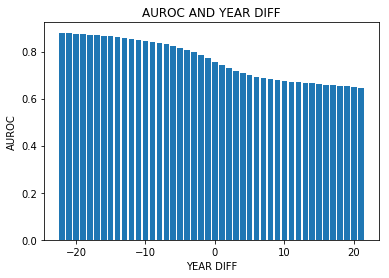

In [35]:
plt.bar(list(aurocs.keys()), list(aurocs.values()))
plt.xlabel('YEAR DIFF')
plt.ylabel('AUROC')
plt.title('AUROC AND YEAR DIFF');

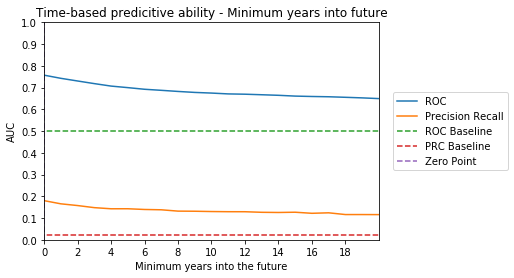

In [36]:
keys = sorted([k for k in aurocs.keys() if k >= 0])

plt.plot(keys, [aurocs[k] for k in keys], label='ROC')
plt.plot(keys, [auprcs[k] for k in keys], label='Precision Recall')
plt.plot([-22, 22], [.5, .5], linestyle='--', label='ROC Baseline')
plt.plot([-22, 22], [1/50, 1/50], linestyle='--', label='PRC Baseline')
plt.plot([0,0], [0,1], linestyle='--', label='Zero Point')
plt.xlabel('Minimum years into the future')
plt.ylabel('AUC')
plt.xlim([0, 20])
plt.ylim([0, 1])
plt.xticks(np.arange(0, 20, 2))
plt.yticks(np.arange(0, 1.1, .1))
plt.title('Time-based predicitive ability - Minimum years into future')
plt.legend(loc='right', bbox_to_anchor=(1.4,.5))
plt.savefig(os.path.join(other_figs, 'min_years_positive.svg'), bbox_inches='tight', pad_inches=0.1);

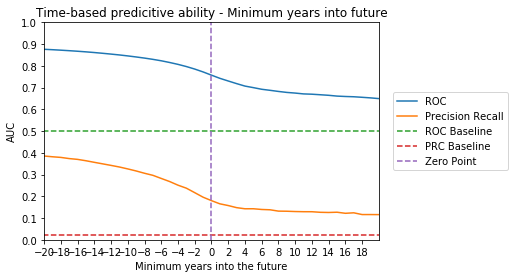

In [37]:
keys = sorted([k for k in aurocs.keys()])

plt.plot(keys, [aurocs[k] for k in keys], label='ROC')
plt.plot(keys, [auprcs[k] for k in keys], label='Precision Recall')
plt.plot([-22, 22], [.5, .5], linestyle='--', label='ROC Baseline')
plt.plot([-22, 22], [1/50, 1/50], linestyle='--', label='PRC Baseline')
plt.plot([0,0], [0,1], linestyle='--', label='Zero Point')
plt.xlabel('Minimum years into the future')
plt.ylabel('AUC')
plt.xlim([-20, 20])
plt.ylim([0, 1])
plt.xticks(np.arange(-20, 20, 2))
plt.yticks(np.arange(0, 1.1, .1))
plt.title('Time-based predicitive ability - Minimum years into future')
plt.legend(loc='right', bbox_to_anchor=(1.4,.5))
plt.savefig(os.path.join(other_figs, 'min_years_pos-neg.svg'), bbox_inches='tight', pad_inches=0.1);

## Rolling averages

Similar analysis as above, but with rolling averages for AUROC at a given time point.  A 1-year rolling average is just the AUROC for that year.  However at deep into the future timepoints, there are very few true postivies to test with.

In [38]:
# data prep
year_cats = preds['year_cat'].dropna().unique()

prepped = {}
for i, diff in enumerate(range(-30, 31)):
        #if diff < -20:
        #    pos_subset = preds.query('year_diff <= @diff and status == 1')
        #elif diff > 20:
        #    pos_subset = preds.query('year_diff >= @diff and status == 1')
        
        pos_subset = preds.query('year_diff == @diff and status == 1')
        neg_subset = preds.query('status == 0 and dataset != "train"').sample(len(pos_subset)*50, random_state=i)

        test_set = pd.concat([pos_subset, neg_subset])
        prepped[diff] = test_set

In [39]:
compare_counts = []

for diff, data in prepped.items():
    count_data = data['status'].value_counts().rename('counts').to_frame()
    count_data = count_data.reset_index()
    count_data = count_data.rename(columns={'index': 'status'})
    count_data['diff'] = diff
    compare_counts.append(count_data)
compare_counts = pd.concat(compare_counts).reset_index(drop=True)

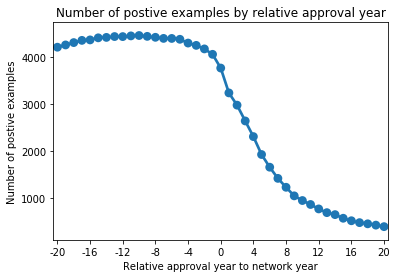

In [40]:
data = compare_counts.query('diff <= 20 and diff >= -20 and status == 1')

sns.pointplot(x='diff', y='counts', data=data)
plt.title('Number of postive examples by relative approval year')
plt.xlabel('Relative approval year to network year')
plt.ylabel('Number of postive examples')
tick_delta = 4
locs, labels = plt.xticks()
plt.xticks(locs[::tick_delta], labels[::tick_delta])
plt.savefig(os.path.join(other_figs, 'pos_ex_by_year_diff.svg'), bbox_inches='tight', pad_inches=0.1);

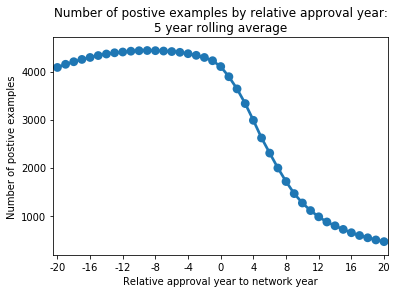

In [41]:
data = compare_counts.query('status == 1').sort_values('diff').reset_index(drop=True)
data['roll_count'] = data.rolling(5).mean()['counts']

data = data.dropna().query('diff >= -20 and diff <= 20')

sns.pointplot(x='diff', y='roll_count', data=data)
plt.title('Number of postive examples by relative approval year:\n5 year rolling average')
plt.xlabel('Relative approval year to network year')
plt.ylabel('Number of postive examples')

tick_delta = 4
locs, labels = plt.xticks()
plt.xticks(locs[::tick_delta], labels[::tick_delta])
plt.savefig(os.path.join(other_figs, 'pos_ex_by_year_diff-5_year_roll.svg'), bbox_inches='tight', pad_inches=0.1);

In [42]:
aurocs = {}
auprcs = {}
for diff in range(-30, 31):
    y = prepped[diff]['status'].values
    y_pred = prepped[diff]['std_probas'].values
    fpr, tpr, thresholds = roc_curve(y, y_pred)                                  
    roc_auc = auc(fpr, tpr)                                                      
    aurocs[diff] = roc_auc
    
    pre, rec, thresholds = precision_recall_curve(y, y_pred)                     
    prc_auc = auc(rec, pre)                                                      
    auprcs[diff] = prc_auc

In [43]:
def get_roc_curve_diff(diff):
    y = prepped[diff]['status'].values
    y_pred = prepped[diff]['std_probas'].values
    
    if diff < 0:
        pt.graph_single_roc(y, y_pred, label='{} years before network'.format(-1*diff))
    elif diff == 0:
        pt.graph_single_roc(y, y_pred, label='Same year as network'.format(diff))
    else:
        pt.graph_single_roc(y, y_pred, label='{} years after network'.format(diff))
    
def get_prc_curve_diff(diff):
    y = prepped[diff]['status'].values
    y_pred = prepped[diff]['std_probas'].values
    
    if diff < 0:
        pt.graph_single_prc(y, y_pred, label='{} years before network'.format(-1*diff))
    elif diff == 0:
        pt.graph_single_prc(y, y_pred, label='Same year as network'.format(diff))
    else:
        pt.graph_single_prc(y, y_pred, label='{} years after network'.format(diff))

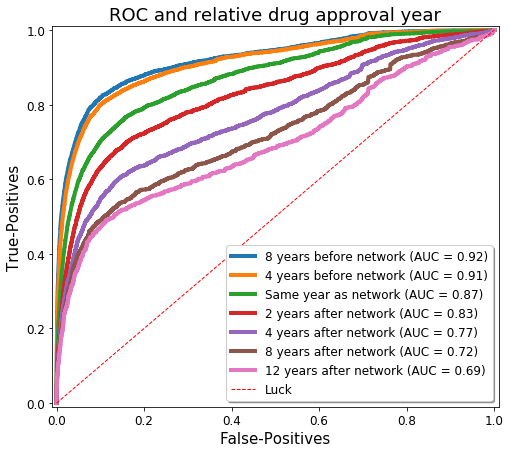

In [44]:
for d in [-8, -4, 0, 2, 4, 8, 12]:
    get_roc_curve_diff(d)
    
pt.graph_roc_boilerplate('ROC and relative drug approval year', size=18)
plt.savefig(os.path.join(other_figs, 'ROC_by_relative_approval_year.svg'), bbox_inches='tight', pad_inches=0.1);

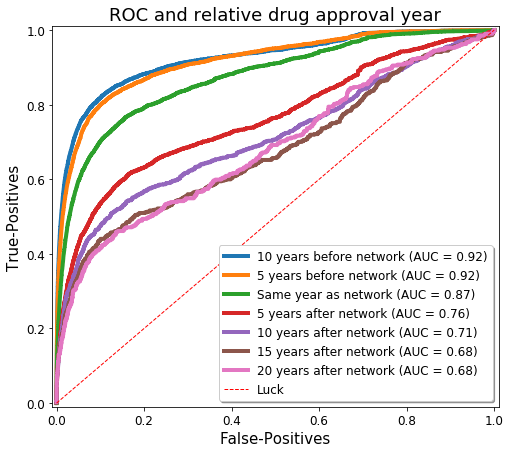

In [45]:
for d in [-10, -5, 0, 5, 10, 15, 20]:
    get_roc_curve_diff(d)
    
pt.graph_roc_boilerplate('ROC and relative drug approval year', size=18)
plt.savefig(os.path.join(other_figs, 'ROC_by_relative_approval_year.svg'), bbox_inches='tight', pad_inches=0.1);

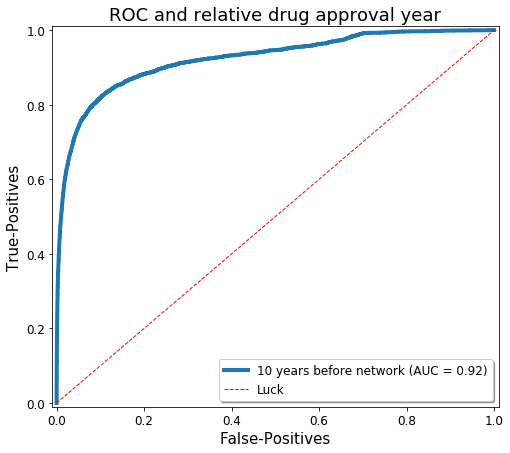

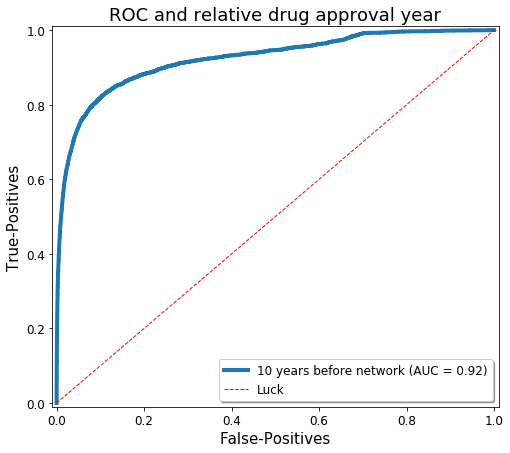

In [46]:
for d in [-10]:
    get_roc_curve_diff(d)
    
pt.graph_roc_boilerplate('ROC and relative drug approval year', size=18)

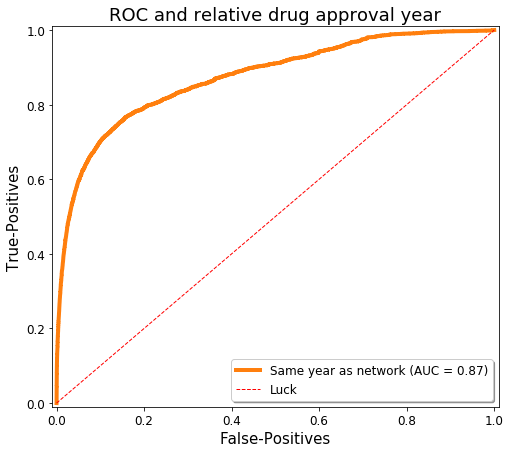

In [47]:
plt.plot(0,0) # Ensure same color by plotting blank line
for d in [0]:
    get_roc_curve_diff(d)
    
pt.graph_roc_boilerplate('ROC and relative drug approval year', size=18);

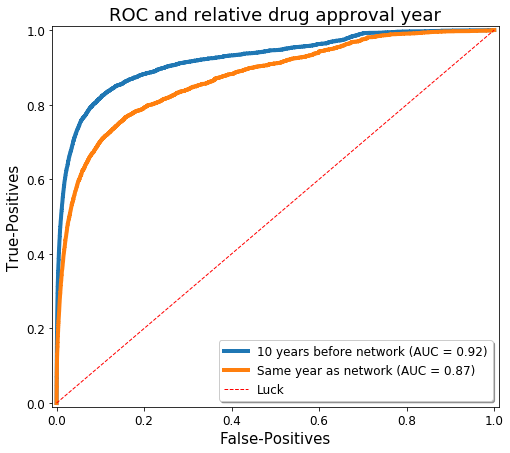

In [48]:
for d in [-10, 0]:
    get_roc_curve_diff(d)
    
pt.graph_roc_boilerplate('ROC and relative drug approval year', size=18);

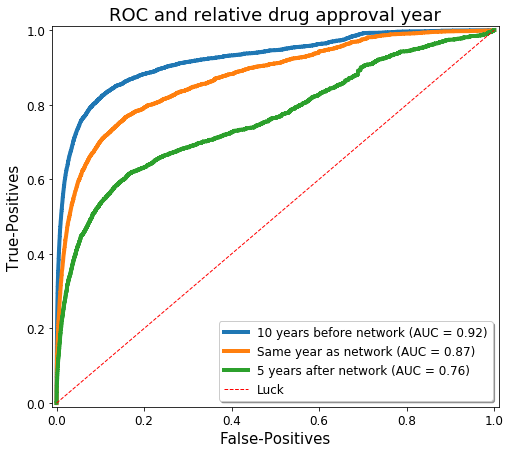

In [49]:
for d in [-10, 0, 5]:
    get_roc_curve_diff(d)
    
pt.graph_roc_boilerplate('ROC and relative drug approval year', size=18);

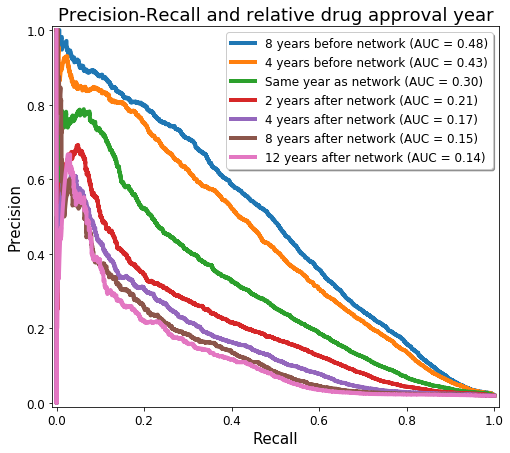

In [50]:
for d in [-8, -4, 0, 2, 4, 8, 12]:
    get_prc_curve_diff(d)
    
pt.graph_prc_boilerplate('Precision-Recall and relative drug approval year', size=18)
plt.savefig(os.path.join(other_figs, 'Pre_rec_by_relative_approval_year.svg'), bbox_inches='tight', pad_inches=0.1);

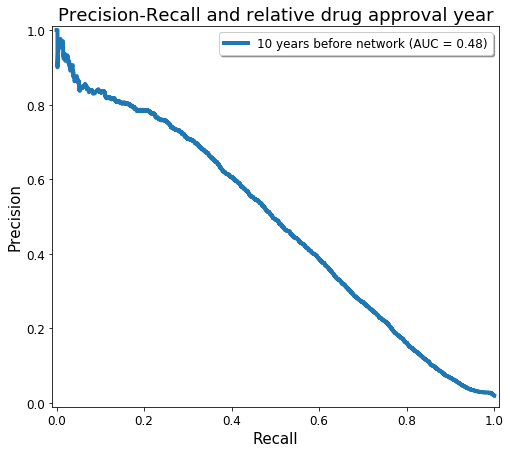

In [51]:
for d in [-10]:
    get_prc_curve_diff(d)
    
pt.graph_prc_boilerplate('Precision-Recall and relative drug approval year', size=18);

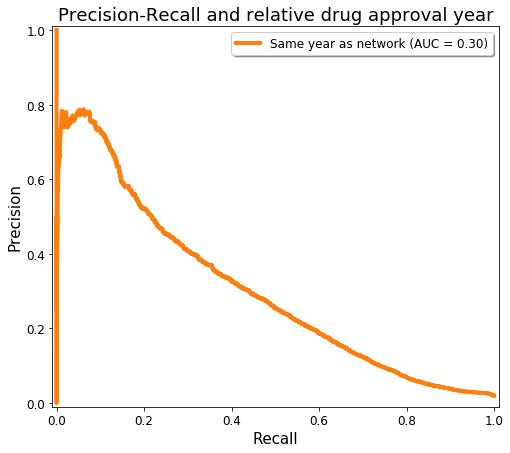

In [52]:
plt.plot(0, 0)  # Ensure same color by plotting blank line
for d in [0]:
    get_prc_curve_diff(d)

pt.graph_prc_boilerplate('Precision-Recall and relative drug approval year', size=18);

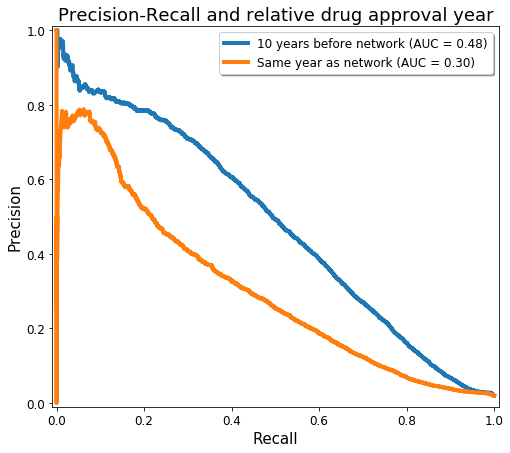

In [53]:
for d in [-10, 0]:
    get_prc_curve_diff(d)
    
pt.graph_prc_boilerplate('Precision-Recall and relative drug approval year', size=18);

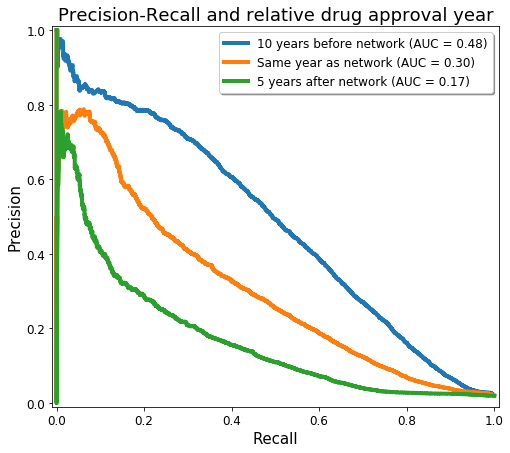

In [54]:
for d in [-10, 0, 5]:
    get_prc_curve_diff(d)
    
pt.graph_prc_boilerplate('Precision-Recall and relative drug approval year', size=18);

In [55]:
data = pd.DataFrame([aurocs, auprcs]).T
data.columns = ['auroc', 'auprc']
data = data.reset_index().rename(columns={'index': 'diff'})

In [56]:
def plot_rolling_roc_avg(data, window, x_min=-20, x_max=20, points=False, point_window=1, 
                         with_polyfit=False, no_line=False):

    if with_polyfit:
        assert points, '\'with_polyfit\' can only be used with the \'points\' option true'
    
    # Function Variables
    label_tail = ''
    title_tail = ''
    legend_shift = 0

    # The rolling average
    roll_avg = data.sort_values('diff').rolling(window).mean().dropna().query('diff >= @x_min and diff <= @x_max')
    
    # Get a rolling average for plotting points as well
    if point_window != 1:
        point_avg = data.sort_values('diff').rolling(point_window).mean().dropna().query('diff >= @x_min and diff <= @x_max')
        title_tail = ' - {} year rolling average'.format(point_window)
    else:
        point_avg = data.query('diff >= @x_min and diff <= @x_max')
    
    if points:
        plt.plot(point_avg['diff'], point_avg['auroc'], marker='x', linestyle='', label='AUROC')
        plt.plot(point_avg['diff'], point_avg['auprc'], marker='o', linestyle='', label='Avg. Precision')        
    
    # Polyfit only makes sense with points
    if with_polyfit:  
        sub_avg = roll_avg.query('diff >= 0 and diff <= @x_max')
        sub_avg1 = roll_avg.query('diff <= 0 and diff >= @x_min')

        p1 = np.poly1d(np.polyfit(sub_avg['diff'], sub_avg['auroc'], 1))
        p2 = np.poly1d(np.polyfit(sub_avg1['diff'], sub_avg1['auroc'], 1))

    # No polyfit, no points, then roling average line should be first
    elif not no_line and not points:
        plt.plot(roll_avg['diff'], roll_avg['auroc'], label='AUROC')
        plt.plot(roll_avg['diff'], roll_avg['auprc'], label='Avg. Precision')
        # Put Rolling average in title
        title_tail = ' - {} year rolling average'.format(window)
        
        
    # Always plot baseline
    plt.plot([x_min,x_max], [.5, .5], linestyle='--', label='ROC Baseline')
    plt.plot([x_min,x_max], [1/50,1/50], linestyle='--', label='PRC Baseline')
    if x_min < 0:
        plt.plot([0,0], [0,1], linestyle='--', label='Zero Point')

    # Plot the Polynomial Fit
    if with_polyfit:
        plt.plot(sub_avg1['diff'], p2(sub_avg1['diff']), label='Trendline Past')
        plt.plot(sub_avg['diff'], p1(sub_avg['diff']), label='Trendline Future')
        legend_shift=.05
    
    # No polyfit but with points, rolling average should come last, longer legends reuire shift
    elif not no_line and points:
        legend_shift = .12
        label_tail = '\n{} year rolling average'.format(window)
        plt.plot(roll_avg['diff'], roll_avg['auroc'], label='AUROC'+label_tail)
        plt.plot(roll_avg['diff'], roll_avg['auprc'], label='Avg. Precision'+label_tail)
    
    # Plot Features and Labels
    plt.xlabel('Relative approval year to network year')
    plt.ylabel('Metric')
    plt.xlim([x_min,x_max])
    plt.ylim([0,1])
    plt.yticks(np.arange(0,1.1, .1))
    plt.title('Time-based predictive ability'+title_tail)
    plt.legend(loc='right', bbox_to_anchor=(1.4+legend_shift,.5));

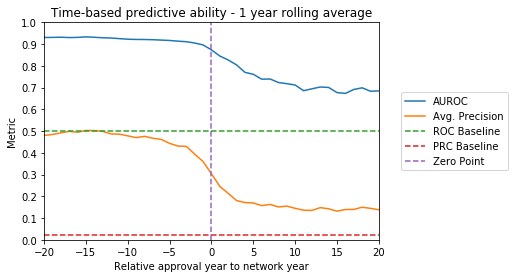

In [57]:
plot_rolling_roc_avg(data, 1)

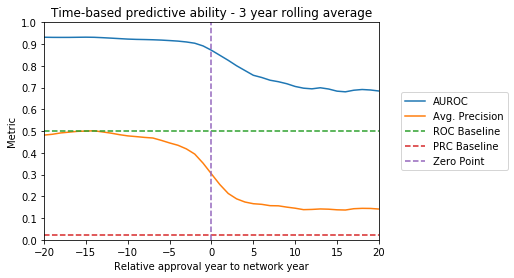

In [58]:
plot_rolling_roc_avg(data, 3)

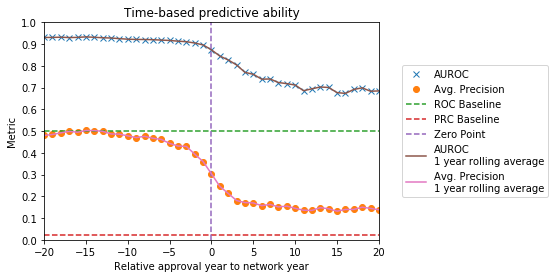

In [59]:
plot_rolling_roc_avg(data, 1, points=True)

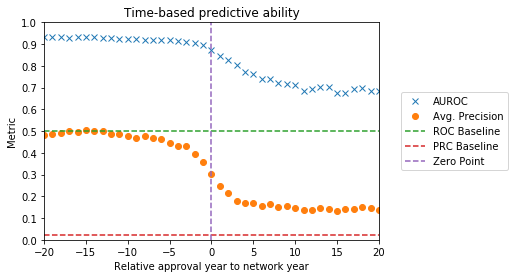

In [60]:
plot_rolling_roc_avg(data, 1, points=True, no_line=True)

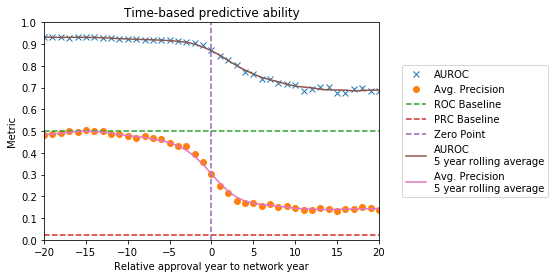

In [61]:
plot_rolling_roc_avg(data, 5, points=True)
plt.savefig(os.path.join(paper_figs, '3C.svg'), bbox_inches='tight', pad_inches=0.1);

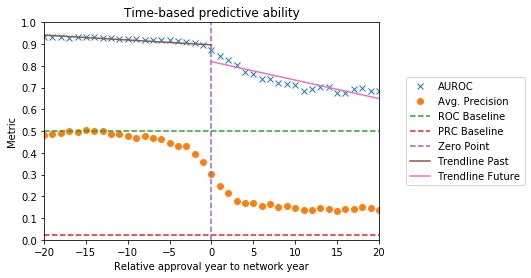

In [62]:
plot_rolling_roc_avg(data, 5, points=True, with_polyfit=True)

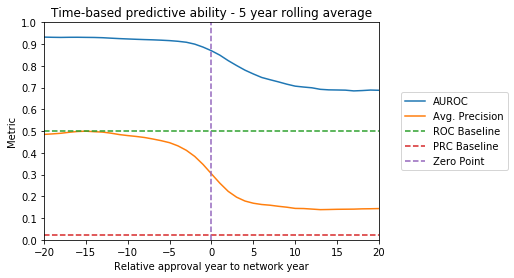

In [63]:
plot_rolling_roc_avg(data, 5)

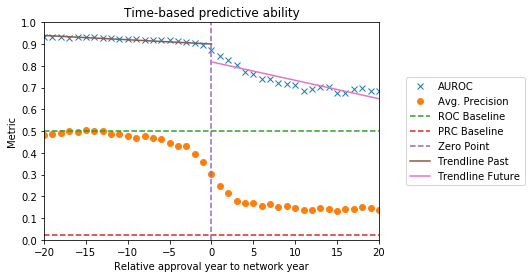

In [64]:
plot_rolling_roc_avg(data, 1, points=True, with_polyfit=True)

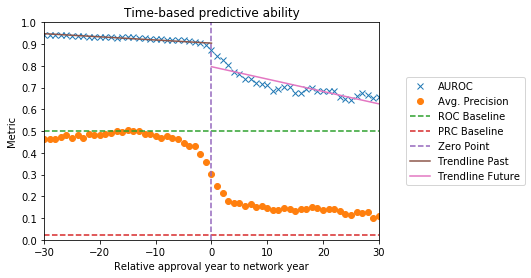

In [65]:
plot_rolling_roc_avg(data, 1, -30, 30, points=True, with_polyfit=True)

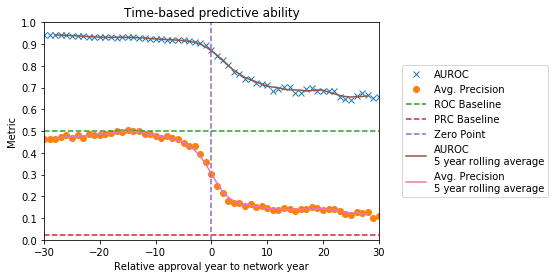

In [66]:
plot_rolling_roc_avg(data, 5, -30, 30, points=True, with_polyfit=False)

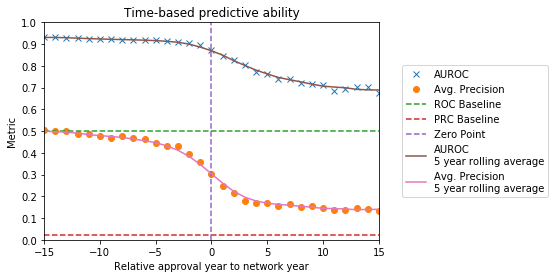

In [67]:
plot_rolling_roc_avg(data, 5, -15, 15, points=True, with_polyfit=False)

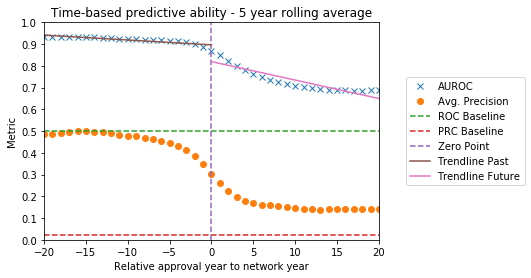

In [68]:
plot_rolling_roc_avg(data, 5, points=True, point_window=5, with_polyfit=True)

In [69]:
data.to_csv(os.path.join(out_dir, 'roc_data.csv'), index=False)